In [3]:
import pandas as pd
import numpy as np

# Graphing
from graph_config import plt


import tqdm as tqdm

from pathlib import Path
import sys

NOTEBOOK_PATH = Path(__file__).resolve() if '__file__' in globals() else Path().resolve()

PROJECT_ROOT = NOTEBOOK_PATH.parent

# Define path to the dataset folder
RAW_DATASET_PATH = PROJECT_ROOT / '01_datasets'/'raw'
PROCESSED_DATASET_PATH = PROJECT_ROOT / '01_datasets'/'processed'

# Define path to output folder
FIGURES_PATH = PROJECT_ROOT / '04_outputs' / '01_figures'
TABLES_PATH = PROJECT_ROOT / '04_outputs' / '02_tables'

# Script paths
SCRIPTS_PATH = PROJECT_ROOT / '03_scripts'


In [19]:
def load_data(filename):
    return pd.read_csv(RAW_DATASET_PATH / filename)

df_tt_og = load_data('Turbine_telemetry.csv')
# df_rd = load_data('Residential_demand.csv')
# df_wd = load_data('kirkwall_weather.csv')

df_tt_og['Timestamp'] = pd.to_datetime(df_tt_og['Timestamp'])

df_tt = df_tt_og.copy()

# Cleaning

## Setting Power to NaN when wind speed is fast enough

In [20]:
# Find the minimum wind speed for power production

v_min = df_tt[(df_tt.loc[:, 'Power_kw'] >= 10.)].loc[:, 'Wind_ms'].quantile(0.1) # 10% quantile minimum speed

print(f"minimum wind speed for power production: {v_min:.2f} m/s")

# Select only rows with Setpoint_kw == 900
# df_tt = df_tt.query('Setpoint_kw==900').copy()

# remove data points when the wind speed is fast enough for power production but there is no power; turbine is probably manually switched off here
df_tt.loc[
    (df_tt['Wind_ms'] >= v_min) & 
    (df_tt['Power_kw'].abs() <= 1e-5) &
    (df_tt['Setpoint_kw'] == 900),
    'Power_kw'
] = np.nan

df_tt[df_tt.isna().any(axis=1)]

# Column Settings
# df_tt['Timestamp'] = pd.to_datetime(df_tt['Timestamp'])
# df_tt['Date'] = df_tt['Timestamp'].dt.date
# df_tt['Time'] = df_tt['Timestamp'].dt.time
# df_tt['Month'] = df_tt['Timestamp'].dt.month

# Clip the power to the setpoint 900 kW
df_tt['Power_kw'] = df_tt['Power_kw'].clip(upper=900)

print(f"turbine telemetry data shape: {df_tt.shape}")

df_tt.head()

minimum wind speed for power production: 5.00 m/s
turbine telemetry data shape: (1069636, 4)


,Timestamp,Power_kw,Setpoint_kw,Wind_ms
0,2015-05-28 00:00:23,80.0,900.0,4.9
1,2015-05-28 00:01:23,78.0,900.0,5.4
2,2015-05-28 00:02:23,52.0,900.0,4.9
3,2015-05-28 00:03:23,57.0,900.0,4.6
4,2015-05-28 00:04:23,54.0,900.0,4.6


## Convert to Timeseries For Resampling

In [42]:
ts_tt = df_tt.set_index('Timestamp')
ts_tt = ts_tt.sort_index()

ts_tt_res = ts_tt.resample('30min').mean()

ts_tt_res_17 = ts_tt_res[
    (ts_tt_res.index >= '2017-01-01') &
    (ts_tt_res.index < '2018-01-02')
]

ts_tt_res_17.shape

(17568, 3)

## Check Longest Consecutive NaN Value

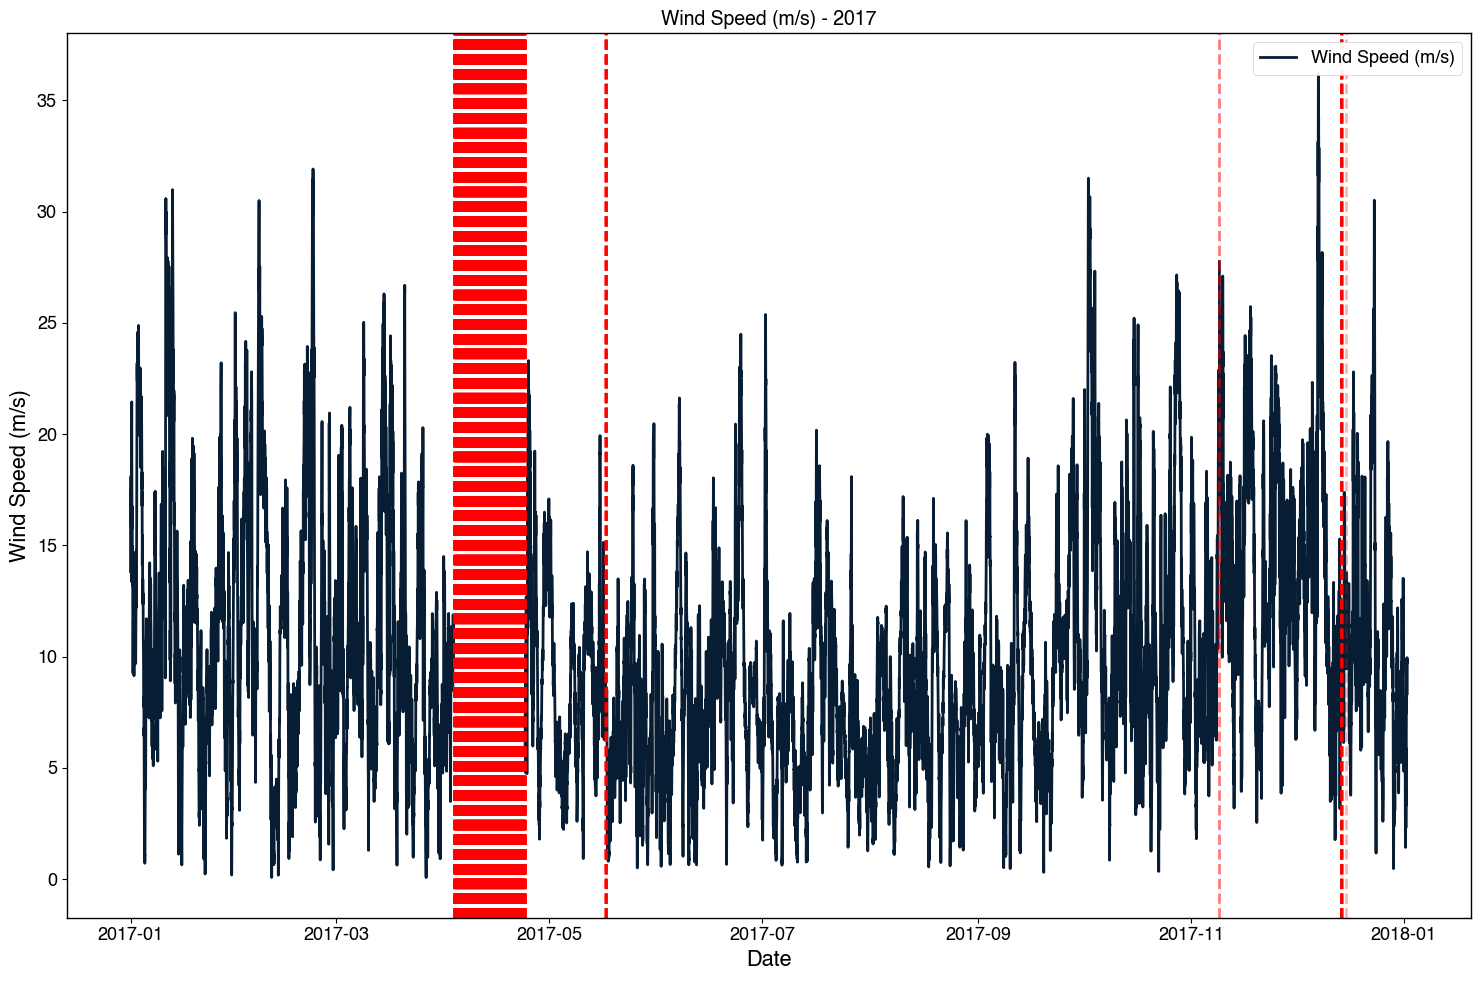

In [46]:
is_nan = ts_tt_res_17['Wind_ms'].isna()

plt.figure(figsize=(15, 10))
plt.plot(ts_tt_res_17.index, ts_tt_res_17['Wind_ms'], label='Wind Speed (m/s)')
# Draw vertical lines for missing data
for t in ts_tt_res_17.index[is_nan]:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.3)
plt.title('Wind Speed (m/s) - 2017')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
wind_is_nan = ts_tt_res_17['Wind_ms'].isna()

start_mask = is_nan & ~is_nan.shift(1, fill_value=False)
end_mask = is_nan & ~is_nan.shift(-1, fill_value=False)

start_times = ts_tt_res_17.index[start_mask]
end_times = ts_tt_res_17.index[end_mask]

nan_ranges_df = pd.DataFrame({
    'Start': start_times,
    'End': end_times
})

nan_ranges_df['Duration'] = nan_ranges_df['End'] - nan_ranges_df['Start']

nan_ranges_df.head(50)

,Start,End,Duration
0,2017-04-03 15:30:00,2017-04-24 02:30:00,20 days 11:00:00
1,2017-05-17 02:30:00,2017-05-17 08:00:00,0 days 05:30:00
2,2017-11-09 02:30:00,2017-11-09 03:00:00,0 days 00:30:00
3,2017-12-13 22:30:00,2017-12-14 05:00:00,0 days 06:30:00
4,2017-12-15 13:00:00,2017-12-15 13:00:00,0 days 00:00:00


## Check Wind-Baseline Wind data

In [72]:
df_wd = load_data(PROCESSED_DATASET_PATH/'df_wd_resampled.csv')

print(f"weather shape: {df_wd.shape}")


df_wd['Timestamp'] = pd.to_datetime(df_wd['Timestamp'])
ts_wd = df_wd.set_index('Timestamp').copy()

ts_wd.head()

weather shape: (17568, 6)


,Temperature (F),Wind Speed (m/s),Humidity (%),Pressure (Hg),Visibility (mi)
Timestamp,,,,,
2017-01-01 00:30:00,41.0,10.28,81.0,30.04,NaN
2017-01-01 01:00:00,43.0,9.39,81.0,30.04,NaN
2017-01-01 01:30:00,41.0,9.83,87.0,30.04,NaN
2017-01-01 02:00:00,39.0,7.15,87.0,30.07,5.0
2017-01-01 02:30:00,41.0,8.94,76.0,30.07,NaN


### Is missing value intersect

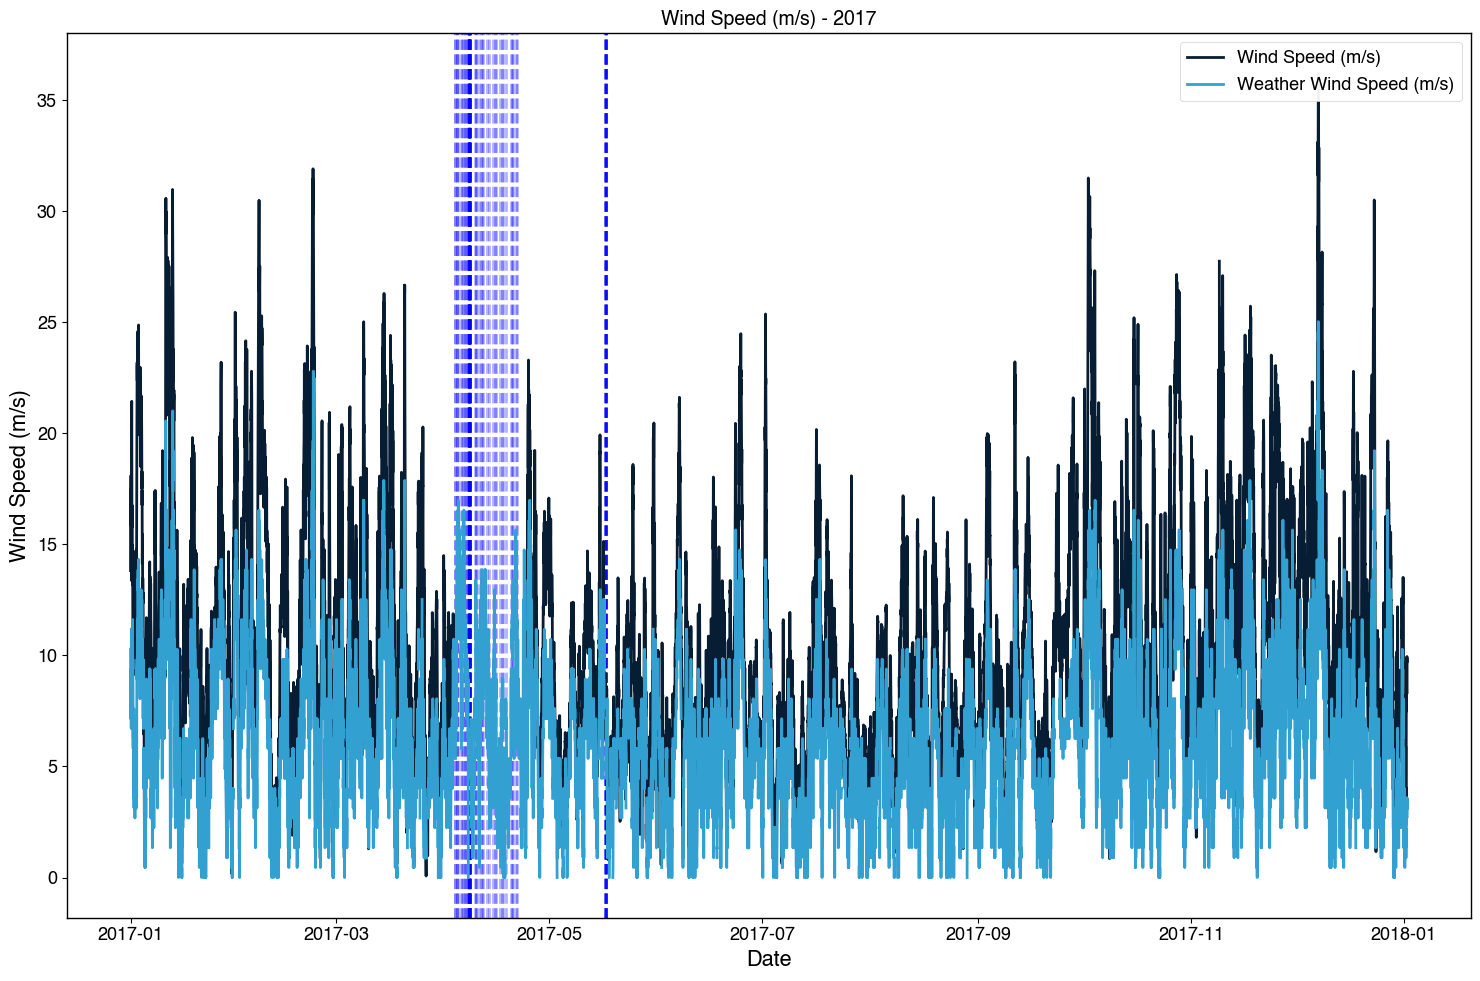

In [88]:
common_index = ts_wd.index.intersection(ts_tt_res_17.index)

df1 = ts_wd.loc[common_index]
df2 = ts_tt_res_17.loc[common_index]

# Step 3: Find timestamps where both have NaN in Wind_ms
both_nan_mask = df1['Wind Speed (m/s)'].isna() & df2['Wind_ms'].isna()

# Step 4: Extract those timestamps into a DataFrame
shared_nan_df = pd.DataFrame({'Timestamp': common_index[both_nan_mask]})

#plot shared NaN timestamps
plt.figure(figsize=(15, 10))
# Draw vertical lines for missing data
for t in shared_nan_df['Timestamp']:
    plt.axvline(x=t, color='blue', linestyle='--', alpha=0.3)
plt.plot(ts_tt_res_17.index, ts_tt_res_17['Wind_ms'], label='Wind Speed (m/s)')
plt.plot(ts_wd.index, ts_wd['Wind Speed (m/s)'], label='Weather Wind Speed (m/s)')

plt.title('Wind Speed (m/s) - 2017')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [86]:
ts_tt_res_17.loc[shared_nan_df['Timestamp'], 'Wind_ms']

Timestamp
2017-04-03 21:30:00   NaN
2017-04-04 03:00:00   NaN
2017-04-04 13:30:00   NaN
2017-04-04 14:30:00   NaN
2017-04-04 18:30:00   NaN
                       ..
2017-05-17 04:30:00   NaN
2017-05-17 05:00:00   NaN
2017-05-17 05:30:00   NaN
2017-05-17 06:00:00   NaN
2017-05-17 06:30:00   NaN
Name: Wind_ms, Length: 65, dtype: float64

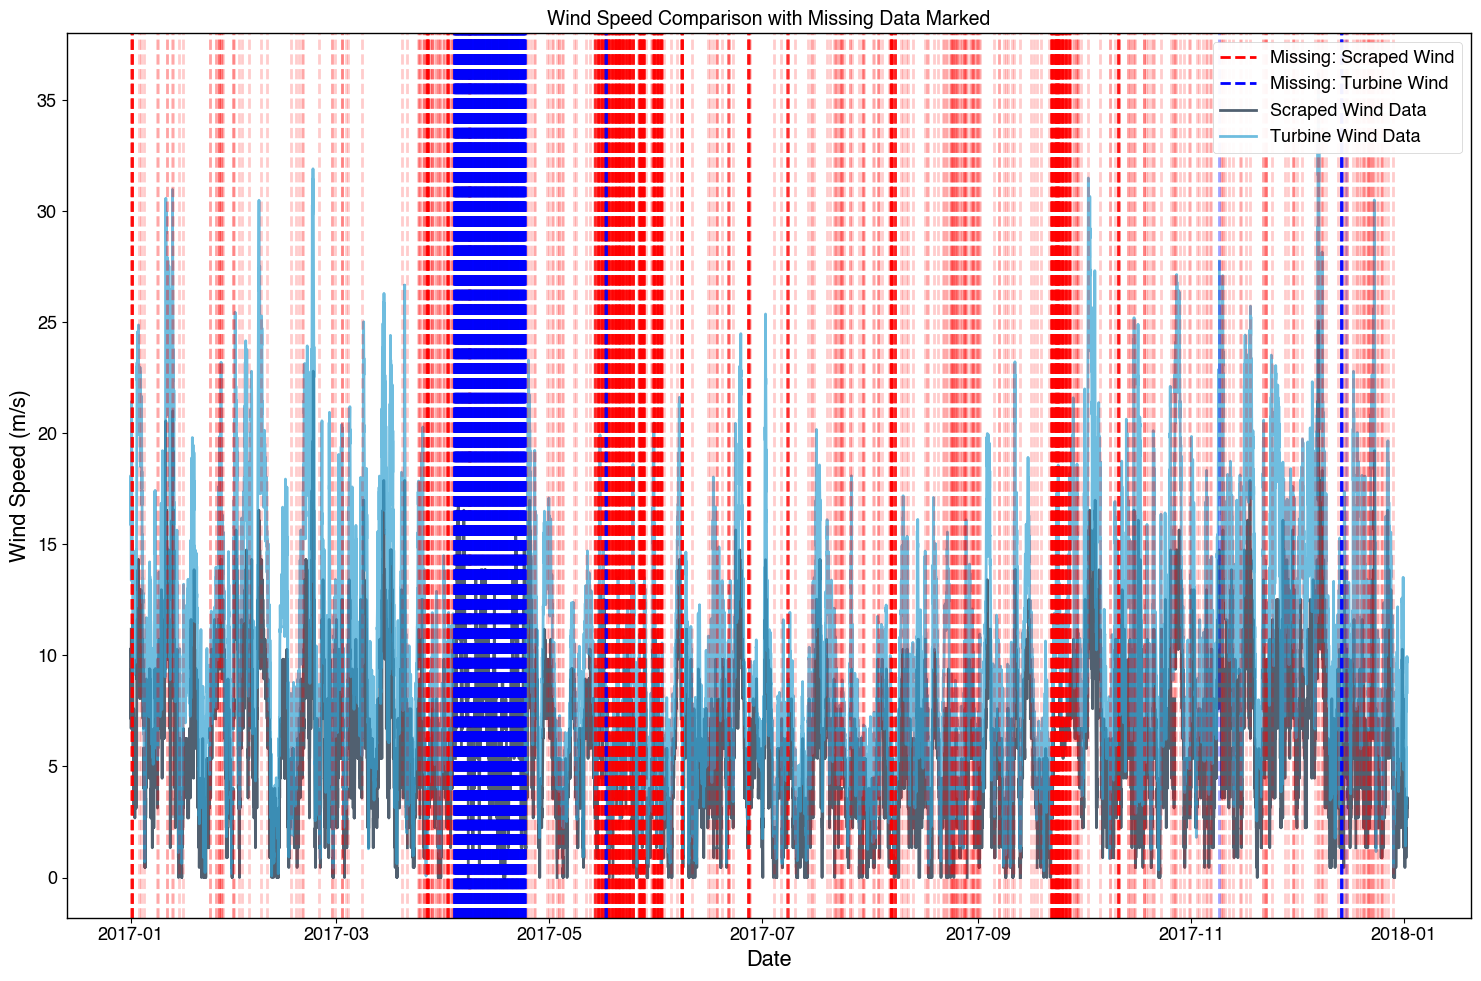

In [74]:
import matplotlib.lines as mlines

missing_df1 = df1['Wind Speed (m/s)'].isna()
missing_df2 = df2['Wind_ms'].isna()

plt.figure(figsize=(15, 10))

plt.plot(df1.index, df1['Wind Speed (m/s)'], label='Scraped Wind Data', alpha=0.7)
plt.plot(df2.index, df2['Wind_ms'], label='Turbine Wind Data', alpha=0.7)

# Add vertical lines for missing values in scraped wind data
for t in df1.index[missing_df1]:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.2)

# Add vertical lines for missing values in turbine wind data
for t in df2.index[missing_df2]:
    plt.axvline(x=t, color='blue', linestyle='--', alpha=0.2)

# Create dummy lines for legend
red_line = mlines.Line2D([], [], color='red', linestyle='--', label='Missing: Scraped Wind')
blue_line = mlines.Line2D([], [], color='blue', linestyle='--', label='Missing: Turbine Wind')

# Add legend
plt.title('Wind Speed Comparison with Missing Data Marked')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend(handles=[red_line, blue_line] + plt.gca().lines[:2])  # legend for lines + dummy markers
plt.grid()
plt.tight_layout()
plt.show()

In [81]:
print(f"missing data in scraped wind data: {missing_df1.sum()}")
print(f"missing data in turbine wind data: {missing_df2.sum()}")

missing data in scraped wind data: 986
missing data in turbine wind data: 1012
